### Small Language Model with Keras/Tensorflow
#### Building a small language model using TinyStories dataset

In [56]:
!pip install onnx tf2onnx onnxruntime

In [57]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import re
from tqdm.auto import tqdm
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, decoders

import keras
import tensorflow as tf
from keras import layers
from keras.preprocessing.sequence import pad_sequences

import onnx
import onnxruntime as ort
from onnxruntime.quantization import quant_pre_process, quantize_dynamic, QuantType

#### Load dataset

Loading the TinyStories data from HuggingFace: https://huggingface.co/datasets/roneneldan/TinyStories

In [3]:
train_ds = load_dataset("roneneldan/TinyStories", split='train[:20000]')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
train_ds[7]

{'text': 'Once upon a time, in a peaceful town, there lived a little boy named Tim. Tim loved to run and play outside. One day, Tim saw a race in the park. He was excited and wanted to join the race.\n\nTim went to his friend, Sarah, and said, "Let\'s start the race!" Sarah smiled and said, "Yes, let\'s go!" They lined up with the other kids and waited for the race to begin. When they heard the word "Go!", they started running as fast as they could.\n\nTim and Sarah ran with all their speed, laughing and having fun. They could feel the wind in their hair as they raced to the finish line. In the end, Tim won the race and Sarah came in second. They were both so happy and proud of themselves. They celebrated with their friends and had a great day at the park.'}

In [5]:
print(f"Total samples in train_ds: {len(train_ds)}")

Total samples in train_ds: 20000


#### Preprocessing & EDA

In [6]:
texts = train_ds['text']

# calculate lengths
char_lengths = [len(t) for t in texts]
word_lengths = [len(t.split()) for t in texts]

df_stats = pd.DataFrame({
    'chars': char_lengths,
    'words': word_lengths
})

print(df_stats.describe())

              chars         words
count  20000.000000  20000.000000
mean     894.545300    175.138400
std      399.782168     80.353075
min      205.000000     43.000000
25%      669.000000    130.000000
50%      785.000000    152.000000
75%      952.250000    185.000000
max     4540.000000    878.000000


In [7]:
def preprocess_text(text):
    text = " ".join(text.split())
    return text + " <|endoftext|>"

cleaned_stories = [preprocess_text(t) for t in texts]

##### Tokenization

In [8]:
tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))

tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=True)

tokenizer.decoder = decoders.ByteLevel()

trainer = trainers.BpeTrainer(
    vocab_size=4096,
    special_tokens=["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
)

tokenizer.train_from_iterator(cleaned_stories, trainer=trainer)

In [9]:
output = tokenizer.encode("Once upon a time, there was a tiny bird.")
print(f"Tokens: {output.tokens}")
print(f"IDs: {output.ids}")

encoded_stories = [tokenizer.encode(s).ids for s in cleaned_stories]

Tokens: ['ĠOnce', 'Ġupon', 'Ġa', 'Ġtime', ',', 'Ġthere', 'Ġwas', 'Ġa', 'Ġtiny', 'Ġbird', '.']
IDs: [289, 300, 109, 255, 13, 258, 133, 109, 1854, 387, 15]


##### Distribution of token length

Median length: 190.0 tokens
90th percentile: 352.0 tokens
95th percentile: 448.0499999999993 tokens
Absolute Max length: 1196 tokens


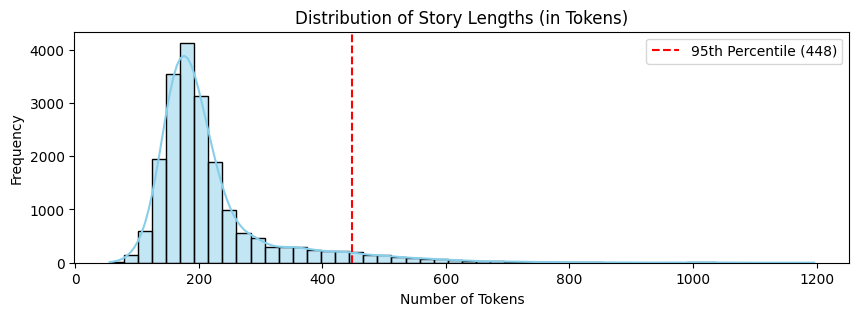

In [10]:
token_lengths = [len(ids) for ids in encoded_stories]

# Calculate key percentiles
p50 = np.percentile(token_lengths, 50)
p90 = np.percentile(token_lengths, 90)
p95 = np.percentile(token_lengths, 95)
max_l = np.max(token_lengths)

print(f"Median length: {p50} tokens")
print(f"90th percentile: {p90} tokens")
print(f"95th percentile: {p95} tokens")
print(f"Absolute Max length: {max_l} tokens")

# Plotting the distribution
plt.figure(figsize=(10, 3))
sns.histplot(token_lengths, bins=50, kde=True, color='skyblue')
plt.axvline(p95, color='red', linestyle='--', label=f'95th Percentile ({int(p95)})')
plt.title("Distribution of Story Lengths (in Tokens)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()

##### Token frequencies

In [11]:
all_tokens = [token_id for story in encoded_stories for token_id in story]

token_counts = Counter(all_tokens)

frequencies = sorted(token_counts.values(), reverse=True)
ranks = np.arange(1, len(frequencies) + 1)

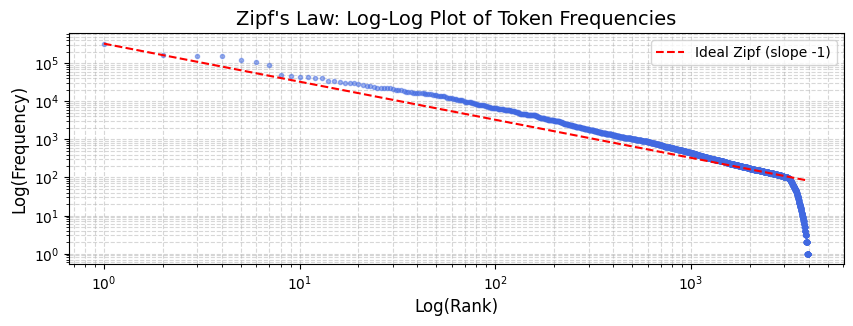

In [12]:
plt.figure(figsize=(10, 3))
plt.loglog(ranks, frequencies, marker=".", linestyle="none", alpha=0.5, color='royalblue')

# Add labels and title
plt.title("Zipf's Law: Log-Log Plot of Token Frequencies", fontsize=14)
plt.xlabel("Log(Rank)", fontsize=12)
plt.ylabel("Log(Frequency)", fontsize=12)
plt.grid(True, which="both", ls="--", alpha=0.5)

# Plot a reference line for ideal Zipf's Law (Slope = -1)
# f(r) = C / r^1 -> log(f) = log(C) - 1*log(r)
line_x = np.array([1, max(ranks)])
line_y = frequencies[0] / line_x
plt.plot(line_x, line_y, color='red', linestyle='--', label='Ideal Zipf (slope -1)')
plt.legend()

plt.show()

##### X_train & y_target

In [13]:
MAX_SEQ_LEN = 128

padded_stories = pad_sequences(encoded_stories,
                               maxlen=MAX_SEQ_LEN,
                               padding='post',
                               truncating='post')

# create the shifted X and Y
x_train = padded_stories[:, :-1]
y_train = padded_stories[:, 1:]

In [14]:
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

dataset = dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)

dataset = dataset.prefetch(tf.data.AUTOTUNE)

for x_batch, y_batch in dataset.take(1):
    print("Batch Input example:", x_batch[0][:10].numpy())
    print("Batch Target example:", y_batch[0][:10].numpy())

Batch Input example: [289 300 109 255  13 258 133 109 770 257]
Batch Target example: [300 109 255  13 258 133 109 770 257 385]


#### Model creation

In [15]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Multi-head attention (Causal mask is applied here later)
        attn_output = self.att(inputs, inputs, use_causal_mask=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = keras.ops.shape(x)[-1]
        positions = keras.ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [16]:
VOCAB_SIZE = 4096
MAX_LEN = 127      # Based on padding step
EMBED_DIM = 256    # Dimensionality of the token vectors
NUM_HEADS = 8      # Number of attention heads
FF_DIM = 512       # Inner layer size of feed-forward network
NUM_LAYERS = 4     # Number of Transformer blocks

keras.mixed_precision.set_global_policy("mixed_float16")

def build_tiny_transformer(vocab_size, max_len, embed_dim, num_heads, ff_dim, num_layers):
    inputs = layers.Input(shape=(max_len,), dtype="int32")

    # Embedding Layer
    embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    # Stack Transformer Blocks
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Output Head
    outputs = layers.Dense(vocab_size, activation=None)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = build_tiny_transformer(
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LEN,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS
)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 127)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 127, 256)       │     1,081,088 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 127, 256)       │     2,367,488 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 127, 256)       │     2,367,488 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 127, 256)       │     2,367,488 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, 127, 256)       │     2,367,488 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 127, 4096)      │     1,052,672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,603,712 (44.26 MB)

 Trainable params: 11,603,712 (44.26 MB)

 Non-trainable params: 0 (0.00 B)

##### Optimizer & lossfn

In [17]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                     ignore_class=0)

optimizer = keras.optimizers.AdamW(learning_rate=1e-4,
                                   weight_decay=0.01,
                                   clipnorm=1.0)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

##### Story generation callback

In [18]:
class StoryGenerator(keras.callbacks.Callback):
    def __init__(self, tokenizer, start_text="Once upon a time", max_tokens=50):
        self.tokenizer = tokenizer
        self.start_text = start_text
        self.max_tokens = max_tokens

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = self.tokenizer.encode(self.start_text).ids
        generated_ids = list(start_tokens)

        for _ in range(self.max_tokens):
            current_window = generated_ids[-127:]

            input_seq = pad_sequences([current_window], maxlen=127, padding='pre')

            preds = self.model.predict(input_seq, verbose=0)

            next_token = np.argmax(preds[0, -1, :])
            generated_ids.append(int(next_token))

            if next_token == 0:
                break

        output_text = self.tokenizer.decode(generated_ids)
        print(f"\n--- Story snippet (Epoch {epoch+1}) ---")
        print(output_text.strip())

gen_callback = StoryGenerator(tokenizer)

#### Model training

In [19]:
history = model.fit(
    dataset,
    epochs=1,
    callbacks=[gen_callback]
)

312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 6.4002 - sparse_categorical_accuracy: 0.1319
--- Story snippet (Epoch 1) ---
Once upon a time. The little girl was so happy. She was so happy to the park. She was so happy and said, "I can't know what was so happy and said, "I can't know what was so happy. She was so happy and
312/312 ━━━━━━━━━━━━━━━━━━━━ 66s 109ms/step - loss: 6.3970 - sparse_categorical_accuracy: 0.1321


##### Hyper-parameter tuning

In [20]:
VOCAB_SIZE = 4096
MAX_LEN = 127      # Based on padding step
EMBED_DIM = 256    # Dimensionality of the token vectors
NUM_HEADS = 8      # Number of attention heads
FF_DIM = 512       # Inner layer size of feed-forward network
NUM_LAYERS = 4     # Number of Transformer blocks

# tuning candidates
learning_rates = [1e-4, 5e-4]
ff_dims = [512, 1024]

results = {}

for lr in learning_rates:
    for ffd in ff_dims:
        model_name = f"lr_{lr}_ff_{ffd}"
        print(f"--- Testing {model_name} ---")

        # build model with specific hyperparameters
        temp_model = build_tiny_transformer(
            vocab_size=VOCAB_SIZE,
            max_len=MAX_LEN,
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEADS,
            ff_dim=ffd,
            num_layers=NUM_LAYERS
        )

        loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                              ignore_class=0)

        optimizer = keras.optimizers.AdamW(learning_rate=lr,
                                            weight_decay=0.01,
                                            clipnorm=1.0)

        temp_model.compile(optimizer=optimizer,
                           loss=loss_fn,
                           metrics=[keras.metrics.SparseCategoricalAccuracy()])

        history = temp_model.fit(dataset, epochs=1, verbose=1)

        # record the final loss for comparison
        results[model_name] = history.history['loss'][-1]

--- Testing lr_0.0001_ff_512 ---
312/312 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - loss: 6.3771 - sparse_categorical_accuracy: 0.1337
--- Testing lr_0.0001_ff_1024 ---
312/312 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - loss: 6.2470 - sparse_categorical_accuracy: 0.1474
--- Testing lr_0.0005_ff_512 ---
312/312 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - loss: 5.0101 - sparse_categorical_accuracy: 0.2211
--- Testing lr_0.0005_ff_1024 ---
312/312 ━━━━━━━━━━━━━━━━━━━━ 61s 96ms/step - loss: 4.9540 - sparse_categorical_accuracy: 0.2285


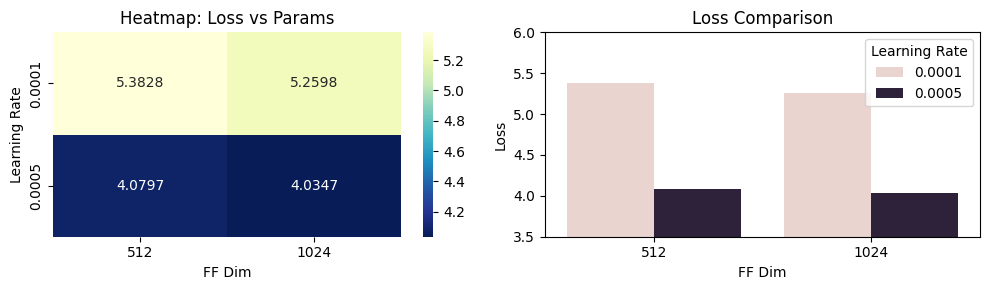

In [21]:
data = []

for key, val in results.items():
    parts = key.split('_')
    lr = float(parts[1])
    ff = int(parts[3])
    data.append({'Learning Rate': lr, 'FF Dim': ff, 'Loss': val})

df = pd.DataFrame(data)

# heatmap
plt.figure(figsize=(10, 3))
pivot_table = df.pivot(index='Learning Rate', columns='FF Dim', values='Loss')

plt.subplot(1, 2, 1)
sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="YlGnBu_r")
plt.title('Heatmap: Loss vs Params')

# barchart
plt.subplot(1, 2, 2)
sns.barplot(data=df, x='FF Dim', y='Loss', hue='Learning Rate')
plt.title('Loss Comparison')
plt.ylim(3.5, 6.0)

plt.tight_layout()
plt.show()

##### Final model training

In [37]:
VOCAB_SIZE = 4096
MAX_LEN = 127      # Based on padding step
EMBED_DIM = 256    # Dimensionality of the token vectors
NUM_HEADS = 8      # Number of attention heads
FF_DIM = 1024      # Inner layer size of feed-forward network
NUM_LAYERS = 4     # Number of Transformer blocks

LR = 5e-4             # Learning rate
WEIGHT_DECAY = 1e-2   # Weight decay
CLIP_NORM = 1.0       # Clip norm


loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                     ignore_class=0)

optimizer = keras.optimizers.AdamW(learning_rate=LR,
                                   weight_decay=WEIGHT_DECAY,
                                   clipnorm=CLIP_NORM)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    dataset,
    epochs=15,
    callbacks=[gen_callback]
)

Epoch 1/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 3.0867 - sparse_categorical_accuracy: 0.3822
--- Story snippet (Epoch 1) ---
Once upon a time, the little girl was so excited to help her find the little girl. She asked her mom if she could help her. She said yes, and the little girl was so happy to have her mommy. She said to the little girl, "I
312/312 ━━━━━━━━━━━━━━━━━━━━ 73s 132ms/step - loss: 3.0863 - sparse_categorical_accuracy: 0.3823
Epoch 2/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 2.7240 - sparse_categorical_accuracy: 0.4241
--- Story snippet (Epoch 2) ---
Once upon a time, the little girl was very sad and she knew what to do. She asked her mom, "What's wrong, I don't know what to do you do?" Her mom replied, "It's a big, but it's important to be
312/312 ━━━━━━━━━━━━━━━━━━━━ 58s 108ms/step - loss: 2.7238 - sparse_categorical_accuracy: 0.4242
Epoch 3/15
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 2.5093 - sparse_categorical_accuracy: 0.4506
--- Stor

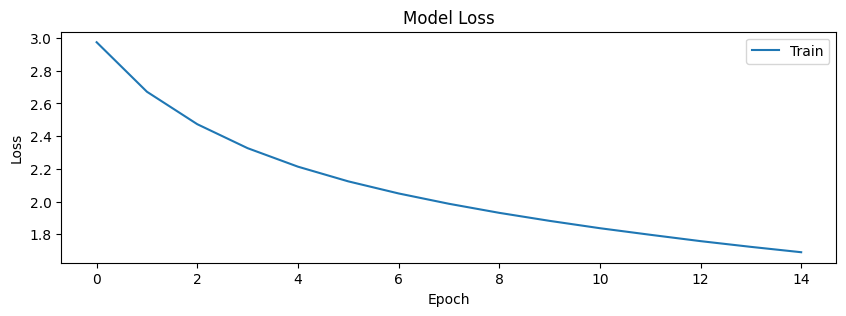

In [38]:
plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [39]:
def generate_story(model, tokenizer, start_text="Once upon a time", max_new_tokens=50, temperature=0.7, k=40):
    input_ids = tokenizer.encode(start_text).ids

    for _ in range(max_new_tokens):
        current_tokens = input_ids[-127:]

        input_seq = pad_sequences([current_tokens], maxlen=127, padding='pre')

        preds = model.predict(input_seq, verbose=0)
        logits = preds[0, -1, :]

        logits = logits / temperature
        top_k_values, top_k_indices = tf.math.top_k(logits, k=k)

        probs = tf.nn.softmax(top_k_values).numpy()
        next_token = np.random.choice(top_k_indices.numpy(), p=probs)

        input_ids.append(int(next_token))

        if next_token in [0, 3]:
            break

    full_story = tokenizer.decode(input_ids)
    return full_story.strip()

print(generate_story(model,
                     tokenizer,
                     start_text="Once upon a time, Lily found a",
                     max_new_tokens=30,
                     temperature=0.7,
                     k=15))

Once upon a time, Lily found a newsp matching matching matching match no new mattress mattress. During the walk, a group heard a happy looking


#### Exporting model

In [53]:
model.export("onnx_model_dir/tiny-stories-slm.onnx", format="onnx")

Saved artifact at 'onnx_model_dir/tiny-stories-slm.onnx'.


In [54]:
session = ort.InferenceSession("onnx_model_dir/tiny-stories-slm.onnx")

input_name = session.get_inputs()[0].name

def test_onnx_generation(tokenizer, start_text="Once upon a time", max_new_tokens=20):
    input_ids = tokenizer.encode(start_text).ids

    print(f"Starting generation with: {start_text}")

    for _ in range(max_new_tokens):
        current_tokens = input_ids[-127:]
        input_seq = pad_sequences([current_tokens], maxlen=127, padding='pre').astype(np.int32)

        outputs = session.run(None, {input_name: input_seq})

        preds = outputs[0]

        next_token = np.argmax(preds[0, -1, :])
        input_ids.append(int(next_token))

        if next_token in [0, 3]: # Stop tokens
            break

    return tokenizer.decode(input_ids)

print(test_onnx_generation(tokenizer, "Once upon a time, Lily loved"))

Starting generation with: Once upon a time, Lily loved
 Once upon a time, Lily loved her matching matching matching matching matching matching mat mattress mattress


##### Quantized model

In [55]:
model_fp32 = "onnx_model_dir/tiny-stories-slm.onnx"
model_quant = "onnx_model_dir/tiny-stories-slm-quantized.onnx"

quantize_dynamic(
    model_input=model_fp32,
    model_output=model_quant,
    weight_type=QuantType.QUInt8
)

print(f"Success! Quantized model saved as: {model_quant}")

Success! Quantized model saved as: onnx_model_dir/tiny-stories-slm-quantized.onnx
